# Hit graph construction

This is a notebook for developing and analyzing the procedure for constructing hit graphs.

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from xtracker.graph_creation import (
    calc_dphi, calc_eta, select_segments, construct_graph, select_hits, split_detector_sections, form_layer_pairs, 
    construct_segments
)


In /home/benjamin/b2/externals/v01-10-00/Linux_x86_64/common/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/belle2.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/benjamin/b2/externals/v01-10-00/Linux_x86_64/common/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/belle2.mplstyle: Support for setting the 'mathtext.fallback_to_cm' rcParam is deprecated since 3.3 and will be removed two minor releases later; use 'mathtext.fallback : 'cm' instead.
In /home/benjamin/b2/externals/v01-10-00/Linux_x86_64/common/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/belle2.mplstyle: 
The validate_bool_maybe_none function was deprecated in Matplotlib 3.3 and will be removed two minor releases later.
In /home/benjamin/b2/externals/v01-10-00/Linux_x86_64/common/lib/python3.8/site-packages/matplotlib/mpl-data/stylelib/belle2_serif.mplstyle: 
The mathtext.fallback_to_cm rcparam was deprecated i

## Read the event data

In [2]:
input_dir = "/home/benjamin/xtracker/examples/data/events_belle2_vtxonly"

In [3]:
evtid = 0

hits = pd.read_hdf(os.path.expandvars( input_dir + '/graph_id_{}.h5'.format(evtid+1) ), 'hits')
truth = pd.read_hdf(os.path.expandvars( input_dir + '/graph_id_{}.h5'.format(evtid+1) ), 'truth')
particles = pd.read_hdf(os.path.expandvars( input_dir + '/graph_id_{}.h5'.format(evtid+1) ), 'particles')

In [4]:
hits.tail()

,particle_id,layer,x,y,z,t,hit_id
115,21,0,-0.113578,-1.583915,-0.487674,0.0,115
116,21,1,-0.141257,-2.297286,-0.831659,0.0,116
117,21,2,-0.222671,-3.923500,-1.614698,0.0,117
118,21,3,-0.641716,-8.988625,-4.051665,0.0,118
119,21,4,-1.269231,-13.962142,-6.459112,0.0,119


In [5]:
particles.tail()

,vx,vy,vz,px,py,pz,q,nhits,particle_id
18,0.028191,-0.093715,0.353338,-0.133458,0.052865,0.268421,-1.0,5,18
19,-0.016549,-0.098441,0.297210,0.081354,0.088550,0.033017,1.0,6,19
20,-0.016549,-0.098441,0.297210,0.047815,0.015226,-0.081506,-1.0,5,20
21,-0.081163,-0.327211,0.116058,-0.008259,-0.482459,-0.231704,1.0,5,21
22,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0,-1


In [6]:
truth.tail()

,hit_id,particle_id,weight
115,115,21,0
116,116,21,0
117,117,21,0
118,118,21,0
119,119,21,0


## Hit selection

In [7]:
pt_min = 0. # GeV

In [8]:
hits = (select_hits(hits, truth, particles, pt_min=pt_min)
        .assign(evtid=0)
        .reset_index(drop=True))

## Geometry ID pairs

We use geometry IDs to select initial set of hit pair segments.
For now we're starting with barrel hits only and can use the layer number as the ID.
We'll then use consecutive layer numbers as the criteria.

In [9]:
n_det_layers = 5
segment_type = 'all'


layer_pairs = form_layer_pairs(n_det_layers, segment_type)

## Segment construction

Now for every layer pair we construct hit-pair segments.

In [10]:
def get_segments(hits, layer_pairs):

    # Group hits by geometry ID
    layer_groups = hits.groupby('layer')

    segments = []
    
    for (layer1, layer2) in layer_pairs:
        # Find and join all hit pairs
        try:
            hits1 = layer_groups.get_group(layer1)
            hits2 = layer_groups.get_group(layer2)
        # If an event has no hits on a layer, we get a KeyError.
        # In that case we just skip to the next layer pair
        except KeyError as e:
            continue
        # Construct the segments
        
        # Start with all possible pairs of hits
        keys = ['evtid', 'r', 'phi', 'z', 'particle_id', 'hit_id', 'layer']
        hit_pairs = hits1[keys].reset_index().merge(
            hits2[keys].reset_index(), on='evtid', suffixes=('_1', '_2'))
        
        # Compute line through the points
        dphi = calc_dphi(hit_pairs.phi_1, hit_pairs.phi_2)
        dz = hit_pairs.z_2 - hit_pairs.z_1
        dr = hit_pairs.r_2 - hit_pairs.r_1
        phi_slope = dphi / dr
        z0 = hit_pairs.z_1 - hit_pairs.r_1 * dz / dr
        
        # We do not have good filter for same layer or ingoing edges
        z0[ hit_pairs.layer_1 >= hit_pairs.layer_2 ] = 0.0 
        phi_slope[ hit_pairs.layer_1 == hit_pairs.layer_2 ] = 0.0 
        
        # Identify the true pairs
        y = (hit_pairs.particle_id_1 == hit_pairs.particle_id_2) & (hit_pairs.hit_id_1+1 == hit_pairs.hit_id_2)
            
        # Put the results in a new dataframe
        segments.append(hit_pairs[['evtid', 'index_1', 'index_2', 'layer_1', 'layer_2']]
                        .assign(dphi=dphi, dz=dz, dr=dr, y=y, phi_slope=phi_slope, z0=z0))
        
    return pd.concat(segments, ignore_index=True)

In [11]:
segments = get_segments(hits, layer_pairs)

In [12]:
segments.describe()

,evtid,index_1,index_2,layer_1,layer_2,dphi,dz,dr,phi_slope,z0
count,7538.0,7538.000000,7538.000000,7538.000000,7538.000000,7.538000e+03,7.538000e+03,7.538000e+03,7538.000000,7538.000000
mean,0.0,59.375431,59.375431,1.927434,1.927434,3.770458e-18,-6.032732e-17,1.206546e-16,-0.007161,-0.038275
std,0.0,34.551420,34.551420,1.302945,1.302945,1.804663e+00,1.001501e+01,2.771102e+00,1.074574,10.047273
min,0.0,0.000000,0.000000,0.000000,0.000000,-3.140820e+00,-5.878630e+01,-5.343870e+00,-7.819872,-106.929186
25%,0.0,30.000000,30.000000,1.000000,1.000000,-1.614554e+00,-3.361225e+00,-8.566759e-01,-0.172220,0.000000
50%,0.0,59.000000,59.000000,2.000000,2.000000,0.000000e+00,0.000000e+00,0.000000e+00,0.000000,0.000000
75%,0.0,89.000000,89.000000,3.000000,3.000000,1.614554e+00,3.361225e+00,8.566759e-01,0.173222,0.000000
max,0.0,119.000000,119.000000,4.000000,4.000000,3.140820e+00,5.878630e+01,5.343870e+00,6.727110,93.056070


## Plot the full segment distributions

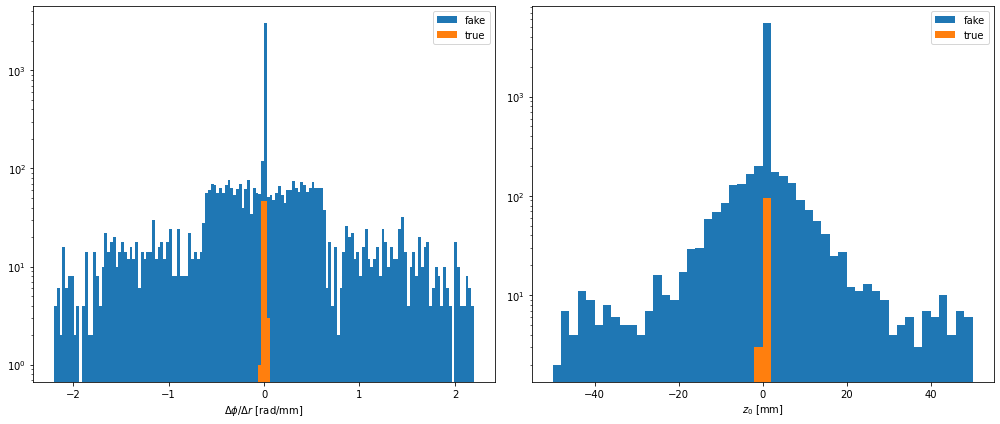

In [13]:
plt.figure(figsize=(14,6))

true_segs = segments[segments.y]
fake_segs = segments[segments.y == False]

plt.subplot(121)
binning=dict(bins=150, range=(-2.2, 2.2))
plt.hist(fake_segs.phi_slope, label='fake', log=True, **binning)
plt.hist(true_segs.phi_slope, label='true', **binning)
plt.xlabel('$\Delta \phi / \Delta r$ [rad/mm]')
plt.legend(loc=0)

plt.subplot(122)
binning=dict(bins=50, range=(-50, 50))
plt.hist(fake_segs.z0, label='fake', log=True, **binning)
plt.hist(true_segs.z0, label='true', **binning)
plt.xlabel('$z_0$ [mm]')
plt.legend(loc=0)

plt.tight_layout()

## Segment selection

In [14]:
def select_segments(segments, phi_slope_min, phi_slope_max, z0_max):
    sel_mask = ((segments.phi_slope > phi_slope_min) &
                (segments.phi_slope < phi_slope_max) &
                (segments.z0 < z0_max) &  (segments.z0 > -z0_max) )
    return segments.assign(selected=sel_mask)

def segment_efficiency(segments):
    return (segments.y & segments.selected).sum() / segments.y.sum()

def segment_purity(segment):
    return (segments.y & segments.selected).sum() / segments.selected.sum()

In [15]:
# Choose some cuts
phi_slope_min = -2.25
phi_slope_max =  2.25
z0_max =  100

In [16]:
segments = select_segments(segments, phi_slope_min=phi_slope_min,
                           phi_slope_max=phi_slope_max, z0_max=z0_max)

print('Selection efficiency %.4f purity %.4f' % (segment_efficiency(segments), segment_purity(segments)))

Selection efficiency 1.0000 purity 0.0140


No handles with labels found to put in legend.
No handles with labels found to put in legend.


Av. selection efficiency 1.0000 purity 0.0128


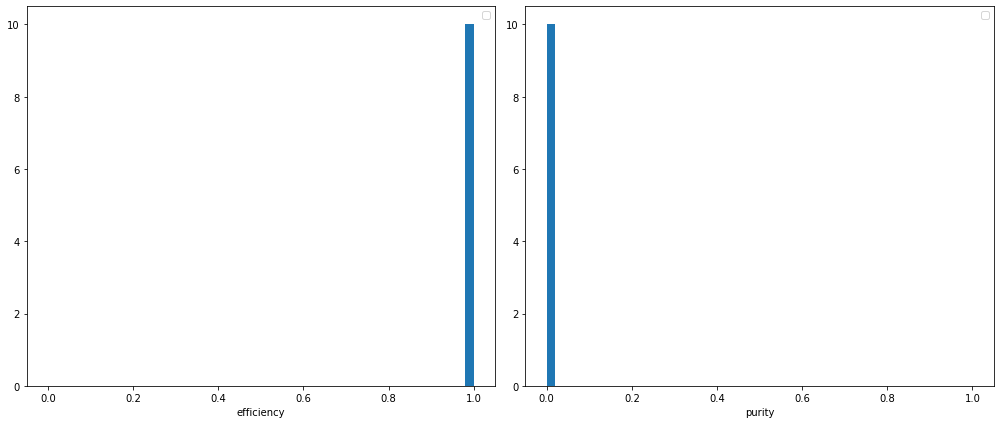

In [17]:
eff = []
pur = []

for evtid in range(10):
    
    hits = pd.read_hdf(os.path.expandvars( input_dir + '/graph_id_{}.h5'.format(evtid+1) ), 'hits')
    truth = pd.read_hdf(os.path.expandvars( input_dir + '/graph_id_{}.h5'.format(evtid+1) ), 'truth')
    particles = pd.read_hdf(os.path.expandvars( input_dir + '/graph_id_{}.h5'.format(evtid+1) ), 'particles')
    
    
    hits = (select_hits(hits, truth, particles, pt_min=pt_min)
        .assign(evtid=0)
        .reset_index(drop=True))
    
    layer_pairs = form_layer_pairs(n_det_layers, segment_type)
    
    segments = get_segments(hits, layer_pairs)
    
    segments = select_segments(segments, phi_slope_min=phi_slope_min,
                           phi_slope_max=phi_slope_max, z0_max=z0_max)
    
    true_segs = segments[segments.y]
    
    eff.append(segment_efficiency(segments))
    pur.append(segment_purity(segments))

print('Av. selection efficiency %.4f purity %.4f' % (np.mean(eff), (np.mean(pur))))


    
plt.figure(figsize=(14,6))

plt.subplot(121)
binning=dict(bins=50, range=(0.0, 1.0))
plt.hist(eff, **binning)
plt.xlabel('efficiency')
plt.legend(loc=0)

plt.subplot(122)
binning=dict(bins=50, range=(0, 1.0))
plt.hist(pur, **binning)
plt.xlabel('purity')
plt.legend(loc=0)

plt.tight_layout()    



## Sample reweighting

To deal with class imbalance, we'll want to reweight the segments in the training loss functions so that real and fake segments have nearly equal proportion.

In [18]:
print('Number of particles: ', particles.shape[0])
print('Number of hits: ', hits.shape[0])
print('Number of segements: ', segments.shape[0])
print('Number of selected segements: ', segments.selected.sum())




# Approximating the sample fractions [fake, real] found above
sample_fracs = np.array([.8, .2])

# Reweight each to 0.5
sample_weights = 0.5 / sample_fracs

sample_weights

Number of particles:  24
Number of hits:  135
Number of segements:  9309
Number of selected segements:  8652


array([0.625, 2.5  ])